# **Práctica 3 Información No Estructurada : Ranking**
### **Miguel Carreras Lahoz y Adrián Rubio Pintado**

In [1]:
from collections import Counter
import numpy as np
import re

# **1. Funciones de ranking no supervisado.**

Dada una pequeña colección "de juguete", calcular el ranking de búsqueda para varias consultas según las siguientes funciones de ránking no supervisado:

<ol type="a">
<li> Coseno TF-IDF (modelo vectorial).
<li> BM25.
<li> Query likelihood.
</ol>

### **1.1 Definir las funciones de ranking a continuación.**

### **Modelo Vectorial**

En el modelo vectorial se presentan documentos y consultas en un espacio vectorial $\mathbb R ^{|V|}$, donde $V$ es el voabulario. Cada coordenada de los vectores de documento para cada $t \in V $ son pesos $d_t = w(t,\bar{d})$ que se calculan con una fórmula basada, como en nuestro caso, en frecuencias. 

Así, el esquema típico de ponderación  y el que utilizaremos será el $\textit tf - idf$, cuyas fórmulas vienen descritas por: 

$$tf(t,d)= \left\lbrace\begin{array}{c} 1~+~log_2~frec(t,d)~si~frec(t,d)~>~0 \\ 0~en~otro~caso \end{array}\right.$$

$$idf(t)= log_2~\frac{|D|}{|D_t|}$$

siendo $D$ la colección de documentos y $D_t$ la de documentos que contienen el término $t$.

Finalmente, dada una consulta $q$, podremos evaluar nuestros documentos mediante:

$$cos(\vec{d},\vec{q})=\frac{\vec{d}\cdot \vec{q}}{|\vec{d}||\vec{q}|}= \frac{\sum_td_tq_t}{\sqrt{\sum_td_t^2} \sqrt{\sum_tq_t^2}} \in [0,1]$$


In [13]:
import math

class VSM:
  def __init__(self, freqvector, docfreqs):
    self.freqvector = freqvector
    self.docfreqs = docfreqs

  def search(self, q):
    # Calculamos el producto tf-idf
    # docs = {url:[word for word in vocabulary] for url in urls}
    # for url in urls:
      # docs[url] = {word: self.tf(word,url)*self.idf(word) for word in vocabulary} # Formato diccionario
    docs = {url:[self.tf(word,url)*self.idf(word) for word in vocabulary] for url in  self.freqvector.keys() } # Formato array
    self.docs = docs

    # Calculamos los cosenos de todos los documentos.
    ranking = [(url, self.dotproduct(url, q) / self.module(url)) for url in self.freqvector]
    # Eliminamos los documentos con coseno = 0.
    ranking = [(url, cos) for url, cos in ranking if cos > 0]
    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking
    
  def dotproduct(self, url, q):
    # Código aquí
    q = np.array([1 if word in q else 0 for word in vocabulary])

    # product = np.sum(self.docs[url][word] for word in q) # Formato diccionario
    product = self.docs[url]@q
    return product 

  def module(self, url):
    # Código aquí
    return np.linalg.norm(self.docs[url])


  def tf(self, word, url):
    # Código aquí
    if(word in self.freqvector[url]):
      return 1 + np.log2(self.freqvector[url][word]) if self.freqvector[url][word] > 0 else 0
    else:
      return 0

    

  def idf(self,word):
    # Código aquí
    return np.log2(len(self.freqvector.keys())/self.docfreqs[word])


  def tf_idf(self):
    docs = {url:(self.tf(word,url)*self.idf(word) for word in vocabulary) for url in urls}
    return docs



### **BM25**

Para calcular el BM25, necesitamos el **RSJ (Fórmula de Robertson & Spark-Jones)**, que se define para cada palabra como w:
$$RSJ(w) = \log_2\frac{|D| - |D_{w}| + 0.5}{|D_{w}| +0.5}$$


Y para cada documento d (usando solo las palabras contenidas tanto en el documento como en la query):

$$RSJ(d) = \sum_{w \in d \cap q}\log_2\frac{|D| - |D_{w}| + 0.5}{|D_{w}| +0.5}$$

Siendo:

$|D|$ : Número de documentos de la colección

$|D_{w}|$: Conjunto de documentos que contienen a w

Utilizando dicha fórumla, definimos la función de ranking del BM25 tal que[1]:

$$ f(q,d) = \sum_{w \in q} \frac{(k+1)frec_{w,d}
}{k(1-b+ b \frac{|d|}{avg_{d'}|d'|}) + freq_{w,d}
}RSJ(w) $$

Siendo:

$|d|:$ longitud de cada doc.
$avg_{d'}|d'|:$ media de las longtiudes de los documentos de la colección.
**Dado que estos dos términos no dependen de la query, los precaculamos al crear el modelo**

* [1] Information Retrieval – Implementing and Evaluating Search Engines Stefan Büttcher, Charles L. A. Clarke, Gordon V. Cormack, 2010 *

In [3]:
class BM25:
  def __init__(self, freqvector,docfreqs, b, k):
    self.freqvector = freqvector
    self.D = len(self.freqvector) #constant
    self.docfreqs = docfreqs
    self.b = b
    self.k = k

    #Precalculamos |d| y avg(|d|)
    self.d = {url:sum(c.values()) for (url,c) in self.freqvector.items()}
    self.avg_d = np.mean([d for d in self.d.values()])

  def search(self, q):
    RSJ_words = self.RSJ(q)
    ranking = [(url,self.score(q,url,RSJ_words) ) for url in self.freqvector.keys() ]
    # Eliminamos los documentos con score = 0.
    ranking = [(url, score) for url, score in ranking if score > 0]
    #Ordenamos el ranking
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def RSJ(self, q):
    '''Devuelve {word:RSJ(w)}
    '''
    #Calculamos |Dw| para cada w en la intersec. de d y q
    Dw = {word: self.docfreqs[word] for word in q if word in self.docfreqs}
    RSJ = {w:np.log2(self.D-dw +0.5/dw +0.5  )  for w,dw in  Dw.items()  }
    #no filtramos las RSJ que son 0 ya que luego el BM25 no aportan al sumario de score(y evitamos el cálculo)
    return RSJ
    
  def score(self, q,d,RSJ_words):
    '''Calcula f(q,d), es decir, el score para cada doc.'''
    denom_factor_comun = self.k * (1 -self.b + (self.b*self.d[d]/self.avg_d) ) 
    sumatorio = [(  ((self.k+1)*self.freqvector[d][w] *RSJ_words[w]) / (denom_factor_comun +self.freqvector[d][w] ) )if self.freqvector[d][w] > 0 else 0  for w in q ]
    return sum(sumatorio)

### **Query likelihood(con suavizado de Laplace (Dirichlet) )**

Ahora vamos a desarrollar un modelo multinomial.

Para el modelo Query Likelihood vemos los documentos como secuencias de palabras con repetición. Para el score del ranking dada una query q y un documento d,suponemos independencia de probabilidad de las palabras que forman el documento:

$$p(q|d) \propto \prod_{w \in q}p(w|d)$$

La probabilidad de una palabra dado un documento de QL con el suavizado de Dirichlet, viene dado por:

$$p(w|d) ≈ \frac{frec(w,d) + \mu p_{c}(w)}{|d| + \mu}$$

Siendo $p_{c}$ , la estimación del modelo background:

$$p_{c} = \frac{\sum_{d' \in D} frec(w,d')}{\sum_{d' \in D} |d'|}  $$

Podemos intrepretar la probabilidad resultante estimada  como la combinación del conteo actual de la palabra junto los pseudo-conteos de la distribución de Dirichlet.

Para eliminarnos el productorio, tomamos el log de $p(q|d)$, así que finalmente, tenemos que **score de una query q y un documento d, lo aproximamos tal que( de acuerdo con [2]):**

$$log((p(q|d)) \approx \sum_{w \in q} log(\frac{frec(w,d) + \mu p_{c}(w)}{|d| + \mu})$$



Como $|d|$ para todos los documentos  y $\sum_{d' \in D}|d'|$, no dependen de la consulta, los precalculamos al crear el modelo.



* [2] Search Engines: Information Retrieval in Practice
W. B. Croft, D. Meltzer, T. Strohman, 2010*

In [4]:
from numpy.core.fromnumeric import prod
class QLD:
  def __init__(self, freqvector, wordfreqs, mu):
    self.freqvector = freqvector
    self.wordfreqs = wordfreqs
    self.mu = mu

    self.d = {url:sum(c.values()) for (url,c) in self.freqvector.items()}
    self.sum_all_d = np.sum([d for d in self.d.values()])
   


  def search(self, q):

    ranking = [(url, self.score(q,url) ) for url in self.freqvector.keys() ]
    # Eliminamos los documentos con score = 0.
    #######ranking = [(url, score) for url, score in ranking if score > 0]
    #Ordenamos el ranking
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking


  def score(self, q, d):

    w_e_q = [ self.score_por_palabra(w,d) for w in q]
    return sum(w_e_q)

  def score_por_palabra(self, w,d):
    freq_w_d = self.freqvector[d][w]
    if(w in self.wordfreqs):
      pc = self.wordfreqs[w]  / self.sum_all_d 
    else:
      pc = 0
    numerador = freq_w_d  + ( self.mu * pc) 
    denominador = self.mu + self.d[d]
    
    return np.log(numerador/ denominador)



Para validar el orden del ranking con las diapositivas de clase, hacemos un pequeño test:

In [14]:
 #TESTEO CON LOS EJEMPLOS DE LAS DIAPOSITIVAS DE CLASE:
urls = ["d1",
        "d2",
        "d3",
        "d4",
        "d5",
        "d6",
        "d7",
        ]

texts = []
texts.append('i think therefore i am')
texts.append('i know one thing that i know nothing')
texts.append('i think to do is to be, to be is to do')
texts.append('you are what you do when it counts')
texts.append('in teaching others we teach ourselves')
texts.append('i cannot live without books')
texts.append('think what next')


# Vector de frecuencias para todos los documentos de la colección, usando la subclase de diccionario collections.Counter.
# Para cada documento, counter almacena un diccionario palabra:frecuencia.
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text.lower()) ]) for url, text in zip(urls, texts)}
# Document frequency para cada palabra del vocabulario.
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}
# Frecuencia total para cada palabra del vocabulario.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Probamos tres consultas.
for q in [['what', 'to', 'think']]:
  print('\n------------------------------')
  print('Query:', q)
  print('\nModelo vectorial')
  for url, score in VSM(freqvector, docfreqs).search(q):
    print(score, url)
  print('\nBM25')
  for url, score in BM25(freqvector,docfreqs, b=1, k=1).search(q):
    print(score, url)
  print('\nQuery likelihood + Dirichlet')
  for url, score in QLD(freqvector, wordfreqs, mu=10).search(q):
    print(score, url)



------------------------------
Query: ['what', 'to', 'think']

Modelo vectorial
0.8521150452175762 d7
0.7895927072844277 d3
0.2742692618329886 d1
0.21666655663425233 d4

BM25
6.560583992279197 d7
5.475449131948801 d3
2.547620580556416 d1
2.3030565424209635 d4

Query likelihood + Dirichlet
-7.0079133821562 d7
-8.054686840843008 d3
-8.646176258915194 d1
-8.926788623651612 d4
-9.588784299106724 d6
-9.782399862519437 d5
-10.135748969488589 d2


El ranking obtenido es el mismo que en las diapositivas, sin embargo no los scores(esto puede ser debido por redondeos o el uso de logaritmos en base distinta a los de las diapositivas). 

Vemos como BM25 guarda mucha relación con Query Likelihood

### **Programa de prueba**

In [15]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import Counter
import re

# La colección: una pequeña lista de URLs web.
urls = ["https://en.wikipedia.org/wiki/Age_of_Enlightenment",
        "https://en.wikipedia.org/wiki/Rationalism",
        "https://en.wikipedia.org/wiki/Scientific_Revolution",
        "https://en.wikipedia.org/wiki/French_Revolution",
        "https://en.wikipedia.org/wiki/Winner%27s_curse",
        "https://en.wikipedia.org/wiki/Simpson%27s_paradox",
        "https://en.wikipedia.org/wiki/Friendship_paradox",
        "https://en.wikipedia.org/wiki/Condorcet_paradox",
        "https://en.wikipedia.org/wiki/Paradox_of_value",
        "https://en.wikipedia.org/wiki/Ship_of_Theseus",
        ]

# Leemos los documentos y quitamos las marcas HTML.
soups = [BeautifulSoup(urlopen(url).read(), "lxml") for url in urls]
for soup in soups: 
  for script in soup(["script", "style"]): script.extract()
texts = [soup.text for soup in soups]

# Una lista ad-hoc de stopwords.
stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# Nos abstraemos de los detalles reales de indexación, y utilizaremos un manejo muy simplificado del texto.

# Vector de frecuencias para todos los documentos de la colección, usando la subclase de diccionario collections.Counter.
# Para cada documento, counter almacena un diccionario palabra:frecuencia.
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text.lower()) if word not in stoplist]) for url, text in zip(urls, texts)}
# Document frequency para cada palabra del vocabulario.
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}
# Frecuencia total para cada palabra del vocabulario.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Probamos tres consultas.
for q in [['descartes', 'montesquieu'], ['thought', 'experiment', 'identity'], ['market', 'paradox']]:
  print('\n------------------------------')
  print('Query:', q)
  print('\nModelo vectorial')
  for url, score in VSM(freqvector, docfreqs).search(q):
    print(score, url)
  print('\nBM25')
  for url, score in BM25(freqvector,docfreqs, b=0.5, k=1).search(q):
    print(score, url)
  print('\nQuery likelihood + Dirichlet')
  for url, score in QLD(freqvector, wordfreqs, mu=3000).search(q):
    print(score, url)


------------------------------
Query: ['descartes', 'montesquieu']

Modelo vectorial
0.05897193965676054 https://en.wikipedia.org/wiki/Rationalism
0.052754926438280794 https://en.wikipedia.org/wiki/Age_of_Enlightenment
0.028494087372643567 https://en.wikipedia.org/wiki/Scientific_Revolution
0.01680258295352459 https://en.wikipedia.org/wiki/French_Revolution

BM25
10.116079761212127 https://en.wikipedia.org/wiki/Age_of_Enlightenment
5.731059999119094 https://en.wikipedia.org/wiki/Rationalism
5.0495224490062105 https://en.wikipedia.org/wiki/Scientific_Revolution
3.8155630230540822 https://en.wikipedia.org/wiki/French_Revolution

Query likelihood + Dirichlet
-15.031918934018663 https://en.wikipedia.org/wiki/Age_of_Enlightenment
-15.089844852679938 https://en.wikipedia.org/wiki/Rationalism
-16.049291703831447 https://en.wikipedia.org/wiki/Paradox_of_value
-16.256413993735272 https://en.wikipedia.org/wiki/Ship_of_Theseus
-16.273897014398813 https://en.wikipedia.org/wiki/Friendship_paradox


Vemos como la salida de Query Likelihood es negativa, ya que hemos tomado el logaritmo en la función de score de cada documento.

### **1.2 Ejecutar y evaluar los métodos anteriores sobre los datos de la práctica 2.**

Calcular alguna métrica y comparar con la efectividad de los buscadores web.

Dado que para nuestra práctica utilizamos **10 consultas**(las que estaban disponibles el día límite), usaremos los mismos ficheros de consultas que los entregados en la **práctica 2.**

Cargamos primero el fichero qrels.csv:

In [5]:
# Carga de los datos
import pandas as pd

In [6]:
from google.colab import files

In [7]:
uploaded = files.upload()


Saving q0.csv to q0.csv
Saving q1.csv to q1.csv
Saving q2.csv to q2.csv
Saving q3.csv to q3.csv
Saving q4.csv to q4.csv
Saving q5.csv to q5.csv
Saving q6.csv to q6.csv
Saving q7.csv to q7.csv
Saving q8.csv to q8.csv
Saving q9.csv to q9.csv
Saving q10.csv to q10.csv
Saving qrels.csv to qrels.csv


In [17]:
qrels = pd.read_csv('qrels.csv')
#seleccionamos las 10 queries
qrels = qrels.drop(qrels[qrels.query_id > 10].index)
#Adaptamos el formato al de pyterrier.
qrels = qrels.drop(['Ignorar_campo'] , axis=1)
qrels.rename(columns = {'query_id':'qid','URL':'docno', 'Nivel_de_acierto':'label'}, inplace = True)
qrels['qid'] = qrels['qid'].astype(str)
qrels.head()

,qid,docno,label
0,0,http://ciir-publications.cs.umass.edu/getpdf.p...,0
1,0,http://citeseerx.ist.psu.edu/viewdoc/download?...,0
2,0,http://citeseerx.ist.psu.edu/viewdoc/summary?d...,2
3,0,http://dictionary.reference.com/browse/informa...,0
4,0,http://dl.acm.org/citation.cfm?id=2499178,0


Creamos ahora el dataframe con las queries:

In [18]:
d = {'qid': ['0', '1','2','3','4','5','6','7','8','9','10'], 'query': ['information theory in information retrieval', 
                                                 'merindades de navarra',
                                                 'festivos madrid 2022',
                                                 'palabras bonitas en euskera',
                                                 'cult propaganda',
                                                 'monsters and demons in 15-16th century art',
                                                 'ranking seo tips and tricks',
                                                 'Club de los 27',
                                                 'mejores peliculas 2021-22',
                                                 'postres típicos por comunidad autónoma',
                                                 'plumas faber castell'
                                                 ]}
queries = pd.DataFrame(data=d)
#queries["qid"] = pd.to_numeric(queries["qid"])
queries

,qid,query
0,0,information theory in information retrieval
1,1,merindades de navarra
2,2,festivos madrid 2022
3,3,palabras bonitas en euskera
4,4,cult propaganda
5,5,monsters and demons in 15-16th century art
6,6,ranking seo tips and tricks
7,7,Club de los 27
8,8,mejores peliculas 2021-22
9,9,postres típicos por comunidad autónoma


Cargamos ahora los ficheros q0...q10, con todos los documentos recopilados para el conjunto de los 4 buscadores que usamos.

In [ ]:
uploadedd = files.upload()

Por problemas de scraping, quitamos las consultas q0 ,q1 y q7 y 10 por tener webs caidas(q0) o ya no disponibles durante esta práctica(tripadvisor y el corteingles dan problemas incluso cambiando el header a la hora de hacerles scrapping). 

In [19]:
#q1 = pd.read_csv('q1.csv')
q2 = pd.read_csv('q2.csv')
q3 = pd.read_csv('q3.csv')
q4 = pd.read_csv('q4.csv')
q5 = pd.read_csv('q5.csv')
q6 = pd.read_csv('q6.csv')
#q7 = pd.read_csv('q7.csv')
q8 = pd.read_csv('q8.csv')
q9 = pd.read_csv('q9.csv')
#q10 = pd.read_csv('q10.csv')

N_QUERIES = 7
q = []
#q.append(q1)
q.append(q2)
q.append(q3)
q.append(q4)
q.append(q5)
q.append(q6)
#q.append(q7)
q.append(q8)
q.append(q9)
#q.append(q10)


for i in range(N_QUERIES):
  q[i] = q[i].drop(['Indicaciones'] , axis=1)
  q[i] = q[i].drop(['Ignorar_campo'] , axis=1)
  q[i] = q[i].drop(['Unnamed: 5'] , axis=1)
  q[i] .rename(columns = {'URL':'docno', 'Nivel_de_acierto':'label'}, inplace = True)
  #q[i]['text'] = ''

Parseamos el texto de las URLs:

In [20]:
import requests 


from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import urllib3
from bs4 import BeautifulSoup
from collections import Counter
import re

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

headers = {
        'Access-Control-Allow-Origin': '*',
        'Access-Control-Allow-Methods': 'GET',
        'Access-Control-Allow-Headers': 'Content-Type',
        'accept': '*/*',
        'accept-encoding': 'gzip, deflate',
        'accept-language': 'en,mr;q=0.9',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36'}

#Creamos index con los TODOS los docs 
docs_tp_pyterrier = []


headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',}
  
for i in range(N_QUERIES):
  texts =  []
  for j in range(len(q[i])):
    url = q[i]['docno'][j]
    #print('i', i+2,'url:', url)
    content = requests.get(url,headers=headers,  verify=False).content
    soup = BeautifulSoup(content, "lxml")
    for script in soup(["script", "style"]): script.extract()
    text = soup.text.lower()
    texts.append(text)
    #pyterrier index
    docs_tp_pyterrier.append( { 'docno' : url, 'text' : text } )

  q[i].insert(3, "text", texts)



**Para cada consulta, usamos el modelo vectorial, BM25 y QLD para hacer un ranking de cada consulta:**

In [61]:
query_ids_used = [2,3,4,5,6,8,9]

vectorial_outputs =  pd.DataFrame(columns=['qid', 'docno',	'Posicion',	'Score'])
bm25_outputs = pd.DataFrame(columns=['qid', 'docno',	'Posicion',	'Score'])
qld_outputs = pd.DataFrame(columns=['qid', 'docno',	'Posicion',	'Score'])

for i in range(N_QUERIES):
    texts_2 = q[i]['text'].to_list()
    urls_2 = q[i]['docno'].to_list()
    freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text.lower()) ]) for url, text in zip(urls_2, texts_2)}
    # Document frequency para cada palabra del vocabulario.
    vocabulary = set()
    for word in freqvector.values(): vocabulary.update(word)
    docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}
    # Frecuencia total para cada palabra del vocabulario.
    wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}
    qid_2 = str(query_ids_used[i])
    query_2 = [w for w in queries.loc[queries['qid'] == qid_2]['query'].values[0].split()]
    #Probamos su query
    print('\n--------------------------------------')
   


    print('Query id:' ,qid_2)
    print('Query:', query_2)

    i = 0
    print('\nModelo vectorial')
    for url, score in VSM(freqvector, docfreqs).search(query_2):
      print(score, url)
      df2 = {'qid':qid_2 , 'docno': url, 'Posicion': i, 'Score': score}
      vectorial_outputs = vectorial_outputs.append(df2, ignore_index = True)

    i = 0
    print('\nBM25')
    for url, score in BM25(freqvector,docfreqs, b=0.5, k=1).search(query_2):
      print(score, url)
      df2 = {'qid':qid_2, 'docno': url, 'Posicion': i, 'Score': score}
      bm25_outputs = bm25_outputs.append(df2, ignore_index = True)

    i = 0
    print('\nQuery likelihood + Dirichlet')
    for url, score in QLD(freqvector, wordfreqs, mu=3000).search(query_2):
      print(score, url)
      df2 = {'qid':qid_2 , 'docno': url, 'Posicion': i, 'Score': score}
      qld_outputs = qld_outputs.append(df2, ignore_index = True)



--------------------------------------
Query id: 2
Query: ['festivos', 'madrid', '2022']

Modelo vectorial
0.008985142020992824 https://calendarios.ideal.es/laboral/comunidad-de-madrid
0.007278521659786924 https://www.calendarr.com/espana/calendario-laboral-madrid/
0.006509068461514273 https://www.calendario-laboral.com/calendario-laboral-madrid-2022
0.006473457414562783 https://dias-festivos.eu/dias-festivos/espana/madrid/2022/
0.005769667538179391 https://www.comunidad.madrid/noticias/2021/09/22/aprobamos-calendario-laboral-2022-12-dias-festivos-dos-locales-fijan-municipios
0.005700202703226902 https://www.elindependiente.com/espana/madrid/2021/12/04/festivos-comunidad-de-madrid-2022-calendario-laboral-y-puentes/
0.005405574053860982 https://calendarios.ideal.es/laboral/comunidad-de-madrid/madrid/madrid
0.004913741869922526 https://www.calendarioslaborales.com/calendario-laboral-madrid-2022.htm
0.004444326954769215 https://www.madrid.es/portales/munimadrid/es/Inicio/Actividad-econom

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log



--------------------------------------
Query id: 6
Query: ['ranking', 'seo', 'tips', 'and', 'tricks']

Modelo vectorial
0.09066633657366435 https://essencesoftwares.com/blog/10-seo-tips-and-tricks-for-higher-seo-ranking-in-2022/
0.08291271920114396 https://seobegood.com/seo-tips-and-tricks-2021/
0.07238139281317146 https://seotoolsportal.com/improve-seo-ranking/
0.06311022288373441 https://www.strikingly.com/content/blog/seo-tips-and-tricks/
0.05988227182722201 https://techprate.com/digital/10-seo-tips-land-higher-rankings/
0.05323585016701908 https://www.mjcreativeventures.com/29-seo-tips-and-tricks/
0.05227274378169788 https://www.webfx.com/blog/seo/seo-tricks/
0.05175497491509628 https://www.rankpay.com/seo-tips-and-tricks/
0.04804839615006927 https://secureyourfuturewithus.com/12-seo-tips-and-tricks-for-higher-rankings
0.04759404650386013 https://khrisdigital.com/seo-tips-and-tricks/
0.04572079463834966 https://www.ewrdigital.com/blog/top-101-seo-tips-and-tricks
0.0423383374911769

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0.07106900060456645 https://pelix.plus/peliculas/2021/page/2///
0.06114880637722931 https://verpeliculasultra.com/xfsearch/peliculas-2021/
0.05333698922090035 https://www.peliculas21.com/peliculas-de-accion/2//
0.020769488098792296 https://www.fotogramas.es/noticias-cine/g34989608/mejores-peliculas-accion-2021//
0.020769488098792296 https://www.fotogramas.es/noticias-cine/g34989608/mejores-peliculas-accion-2021/
0.016837253766286517 https://www.pocket-lint.com/es-es/tv/noticias/131995-las-mejores-peliculas-proximas-las-mejores-peliculas-proximamente-vea-los-trailers-aqui
0.016171825353077058 https://www.sensacine.com/peliculas/mejores-peliculas/
0.015107794924707468 https://www.esquire.com/es/actualidad/cine/g38387355/mejores-peliculas-2022-fechas-estreno/
0.014198086095565247 https://www.superaficionados.com/mejores-peliculas-accion/
0.01405393346072603 https://www.esquire.com/es/actualidad/cine/g38672155/mejores-peliculas-2021-plataformas-netflix-disney-hbo-amazon-filmin//
0.01370247

Calculamos ahora Precision, Recall y Media Armónica, con los datos almacenados de los rankings que acabmos de imprimir por pantalla

In [ ]:
#Tenemos las salidas almacenadas en 
#vectorial_outputs 
#bm25_outputs 
#qld_outputs 
#Diferenciadas por la query id, ahora junto a qrels que tenemos vamos a calcular las metricas descritas, para ello recuperamos la siguiente función de la anterior práctica:

In [78]:
def calc_metrics_por_consulta(qi_rels, qi_returned):
    '''
        Calcula precision y recall para una consulta
        Args:
            qi_rels:urls  relvantes para la consulta i
            qi_returned: urls  returned para la consulta i
    '''
    intersection = pd.merge(qi_rels, qi_returned, how='inner', on=['docno'])

    if(len(qi_returned) == 0 ):
      precision = 0
    else: 
      precision = len(intersection)/len(qi_returned)

    if(len(qi_rels) == 0 ):
      recall = 0
    else: 
      recall = len(intersection)/len(qi_rels)


    if((precision + recall) == 0 ):
      m_armonica = 0
    else:
      m_armonica = (2*precision*recall)/ (precision + recall)
    return  precision, recall, m_armonica 

#para cada query id que hemos usado, promediamos las métricas

def promedia_por_modelo(qrels, model_outputs,nombre_modelo):

    precisions = []
    recalls = []
    m_armonicas = []

    qrels = qrels.loc[qrels['label']>0]

    for i in query_ids_used:
        #Filtering by query id
        qi_rels = qrels.loc[qrels['qid'] == str(i)]
        qi_rels_with_zeros = qi_rels
        qi_returned  = model_outputs.loc[model_outputs['qid'] == str(i)]
        
        #Metrics calc
        preci, recall, armonica = calc_metrics_por_consulta(qi_rels['docno'], qi_returned)
        precisions.append(preci )
        recalls.append(recall )
        m_armonicas.append(armonica)
      
    print('MODELO: ', nombre_modelo)
    print('\t\t Precision:',np.average(precisions))
    print('\t\t Recall:', np.average(recalls) )
    print('\t\t Media Armónica:', np.average(m_armonicas) )



**Obteniendo finalmente las métricas promediadas por cada consulta:** (con los hiperparámetros especificados arriba)

In [79]:
promedia_por_modelo(qrels, vectorial_outputs, 'Vectorial')

MODELO:  Vectorial
		 Precision: 0.7746286899514797
		 Recall: 0.945259420382573
		 Media Armónica: 0.8364567323873384


In [80]:
promedia_por_modelo(qrels, bm25_outputs, 'BM25')

MODELO:  BM25
		 Precision: 0.6317715470943368
		 Recall: 0.8095451346682874
		 Media Armónica: 0.6972625931931992


In [81]:
promedia_por_modelo(qrels, qld_outputs, 'QLD') 

MODELO:  QLD
		 Precision: 0.758527494011365
		 Recall: 1.0
		 Media Armónica: 0.8491591690744232


Podemos comparar con los datos obtenidos con los buscadores de la práctica anterior:
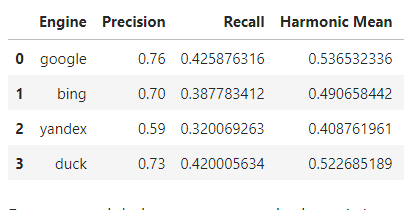

Vemos como los métodos de ranking no supervisado mejorar a los comerciales(en precision y en media armónica), sin embargo, cabe destacar que hemos alimentado los modelos no supervisados con datos ya obtenidos de los supervisados(comerciales), con lo que cuentan con esta ventaja de disponer de la mayoría de elementos ya relevantes. Además el conjunto de datos no es extremadamente grande como para poder extraer conclusiones realmente determinantes.

Por último ejecutamos los datos de la práctica anterior con la librería **pyterrier**, obteniendo las siguientes métricas para cada uno de los modelos no supervisados:

In [ ]:
#Creamos el index con todos los docs de las queries
iter_indexer = pt.IterDictIndexer("./indexTest_ejercicio_1___2", meta=['docno', 'text'], meta_lengths=[20, 177505])
indexref1 = iter_indexer.index(docs_tp_pyterrier)

In [ ]:
# Creamos y probamos rankers no supervisados por VSM, BM25, QLD y otros.
vsm = pt.BatchRetrieve(indexref1, wmodel='TF_IDF')
bm25 = pt.BatchRetrieve(indexref1, wmodel='BM25F')
qld = pt.BatchRetrieve(indexref1, wmodel='DirichletLM')
pl2 = pt.BatchRetrieve(indexref1, wmodel='PL2')
dph = pt.BatchRetrieve(indexref1, wmodel='DPH')

# Calculamos varias métricas
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50],
     queries, qrels, [P@10, nDCG, nDCG@10, RR], baseline=0, sort=nDCG@10)

                      name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
                   DFR DPH 0.511364 0.454545 0.454880 0.414784   0.0   0.0         NaN     3.0     0.0      0.081553     4.0     3.0      0.832282        5.0        1.0         0.040096
Query likelihood Dirichlet 0.515152 0.463636 0.456446 0.399740   1.0   1.0    0.884461     1.0     0.0      0.340893     3.0     4.0      0.790334        1.0        4.0         0.679594
          Modelo vectorial 0.511364 0.427273 0.454313 0.391850   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN           NaN        NaN        NaN              NaN
                      BM25 0.510101 0.427273 0.448567 0.390915   0.0   1.0    0.340893     1.0     1.0      1.000000     2.0     5.0      0.530889        2.0        4.0         0.956062
       DFR Poisson Laplace 0.412879 0.390909 0.409381 0.326496   1.0  

# **2. Búsqueda con funciones no supervisadas implementadas en la librería PyTerrier.**

### **Ejemplo**

In [ ]:
# Uitlizamos la librería de motor de búsqueda PyTerrier.
!pip install python-terrier
import pyterrier as pt
if not pt.started(): pt.init()
!pip install ir-measures
from pyterrier.measures import *

In [ ]:
def printsearch(name, model, q):
  print('\n' + name)
  print((model).search(q)[['score', 'docno']].to_string(index=False))

def eval(names, models, queries, qrels, metrics, sort=False, baseline=None):
  if not sort: sort=models[0]
  # Lla clase Experiment ejecuta rankers sobre una batería de consultas, y calcula métricas.
  # El parámetro "baseline" hace que se añadan p-valores (y nº de consultas ganadas/perdidad) respecto a uno de los rankers (por defecto el primero de la lista).
  # Devolvemos la tabla de métricas ordenada por una de las métricas ("sort").
  print(pt.Experiment(models, queries, qrels, metrics, names, baseline=baseline).sort_values(str(sort), ascending=False).to_string(index=False))

# Accedemos a una colección "Vaswani" ya construida e indexada en PyTerrier.
dataset = pt.datasets.get_dataset('vaswani')
index = pt.IndexFactory.of(dataset.get_index('terrier_stemmed_text'))
queries = dataset.get_topics()
qrels = dataset.get_qrels()

# Sacamos una consulta cualquiera del conjunto de datos para probar los rankers.
q = queries[queries.qid=='5']['query'].values[0]

# Creamos y probamos rankers no supervisados por VSM, BM25, QLD y otros.
vsm = pt.BatchRetrieve(index, wmodel='TF_IDF')
bm25 = pt.BatchRetrieve(index, wmodel='BM25F')
qld = pt.BatchRetrieve(index, wmodel='DirichletLM')
pl2 = pt.BatchRetrieve(index, wmodel='PL2')
dph = pt.BatchRetrieve(index, wmodel='DPH')
print('Query:', q)
# El operador "%n" de PyTerrier pide al modelo que produzca sólo el top n del ranking.
printsearch('Modelo vectorial', vsm%10, q)
printsearch('BM25', bm25%10, q)
printsearch('Query likelihood Dirichlet', qld%10, q)

# Calculamos varias métricas
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50],
     queries, qrels, [P@10, nDCG, nDCG@10, RR], baseline=0, sort=nDCG@10)

data.direct.bf:   0%|          | 0.00/388k [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/234k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/362k [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/682k [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/777 [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/30.3k [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/725k [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/89.3k [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/2.07M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.31k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/619 [00:00<?, ?iB/s]

query-text.trec:   0%|          | 0.00/3.05k [00:00<?, ?iB/s]

qrels:   0%|          | 0.00/6.63k [00:00<?, ?iB/s]

Query: use of programs in engineering testing of computers

Modelo vectorial
    score docno
14.442821  1586
12.833733 11429
10.506225  7875
 9.889541  3559
 9.809790  2290
 9.737880  5130
 9.486759  4307
 9.451995  4308
 9.403773  9165
 9.344073 10156

BM25
    score docno
28.368006  1586
23.553835 11429
20.804721  2290
20.194568  7875
19.803231 10156
19.295740  5130
19.203330  3559
17.927556  2927
17.740540   148
17.598424  2511

Query likelihood Dirichlet
   score docno
3.305896  1586
3.287824  2373
3.002635 11429
2.937968  3559
2.570817  4307
2.495430  4709
2.434525   276
2.379995  5538
2.292910  7875
2.283731  4308
                      name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
          Modelo vectorial 0.698671 0.359140 0.438444 0.444411   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN           NaN        NaN        NaN              NaN


### **Ejercicio: probar más modelos no supervisados y métricas de PyTerrier**

La lista completa de rankers de PyTerrier está disponible en http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html.

La lista de métricas en https://pyterrier.readthedocs.io/en/latest/experiments.html.

**Respuesta:**

Dentro de los diferentes modelos no supervisados que ofrece PyTerrier podemos diferenciar dos grandes clases. La primera de ellas, son los modelos que pesan la ocurrencia de términos mientras que los otros se centran en los campos en los que aparecen dichos términos. 

A su vez, la primera clase descrita se puede dividir en diferentes subfamilias según su metología: 
* IDF: los ejemplos más conocidos son TF_IDF y BM25
* Divergencia por aleatoriedad: aquí se incluyen dos modelos usados en el anterior ejemplo, los modelos DFR. Además, en esta familia existen otras variantes que cuyos modelos son hipergeométricos.
* Modelos de lenguaje: en clase hemos estudiado el modelo DirichletLM
* Divergencia por independencia: p. ej. el modelo DFI

Así, en el anterior ejemplo hemos probado 3 de los modelos vistos en clase como lo son TF_IDF, BM25 (en el ejemplo era el BM25F, una versión del BM25 basada en el campo del término)y DirichletLM. Además, se han añadido en el ejemplo dos modelos nuevos relacionados con la segunda familia (Divergencia por aleatoriedad). 

Los mejores resultados se han obtenido para el modelo TF_IDF siguiendo con la pareja de modelos DFR (Divergence from randomness).

Siguiendo con la prueba, vamos a evaluar que tipo de familia obtiene mejores resultados para nuestros datos. Además, vamos a añadir algunas métricas nuevas vistas en clase como R (Recall) o ERR (Expected Reciprocal Rank) y algunas que implementa Pyterrier como Sucess* y Judge**.

\*Success $\equiv$ 1 si en los primeros documentos seleccionados se encuentra al menos un documento con relevancia relativa, en caso contrario 0. 
**Judge $\equiv$ porcentaje de resultados en el top k (corte) que contienen juicios de relevancia.


In [ ]:
# Mantenemos las 3 primeros modelos y los comparamos 
vsm = pt.BatchRetrieve(index, wmodel='TF_IDF')
bm25 = pt.BatchRetrieve(index, wmodel='BM25F') 
qld = pt.BatchRetrieve(index, wmodel='DirichletLM')
# 1ª subfamilia (más variaciones)
bm25_raw = pt.BatchRetrieve(index, wmodel='BM25')
# 2ª subfamilia 
pl2 = pt.BatchRetrieve(index, wmodel='PL2')
# 4ª subfamilia
dfi = pt.BatchRetrieve(index, wmodel='DFIZ')


# Calculamos varias métricas
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet',  'BM25 (original)','PL2','DFI-Standardization'],
     [vsm%50, bm25%50, qld%50, bm25_raw%50,pl2%50, dfi%50],
     queries, qrels, [P@10, nDCG, nDCG@10, RR, R@10, ERR@10, Success@10, Judged@10], baseline=0, sort=nDCG@10)

                      name       RR     P@10     R@10     nDCG  nDCG@10  Success@10  Judged@10   ERR@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  R@10 +  R@10 -  R@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value  Success@10 +  Success@10 -  Success@10 p-value  Judged@10 +  Judged@10 -  Judged@10 p-value  ERR@10 +  ERR@10 -  ERR@10 p-value
       DFI-Standardization 0.715599 0.374194 0.228588 0.438227 0.453790    0.892473   0.373118 0.079285  15.0  13.0    0.310124    28.0    14.0  7.047662e-02    28.0    14.0      0.194974    44.0    42.0  9.663300e-01       43.0       32.0     2.358912e-01           1.0           1.0            1.000000         27.0         13.0       6.571944e-02      39.0      36.0    4.675665e-01
           BM25 (original) 0.725126 0.352688 0.218513 0.442753 0.446609    0.881720   0.351613 0.079477  13.0   3.0    0.026092     2.0     8.0  5.734926e-02     2.0     8.0      0.324885    38.0    41.0  2.942729e-01       16.0

Finalmente, tras usar (por lo menos) un modelo de cada clase y subfamilia, podemos hacer una valoración final de todos ellos:

Como claro vencedor en casi todas las métricas encontramos al modelo DFI-Z (perteneciente a la subfamilia "Divergencia por independencia"). Además, entre los siguientes puestos con mejores resultados están los modelos vectorial, BM25 y los DFR (2ª subfamilia). 

Por abajo, el modelo que peor ha rankeado nuestros documentos ha sido el Dirichlet_LM.

# **3. Learning to rank con características de texto.**

Se trata de jugar con las características. No siempre podremos mejorar los resultados. Una opción es jugar con los parámetros de Landamar.

Para ello, comenzamos variando los parámetros de nuestro modelo GBDT

### **Ejemplo**

In [ ]:
import numpy as np
import lightgbm as lgb

# Definimos el vector de características, e indicamos la función de ranking para el primer filtro de candidatos "first stage ranking".
fsr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["SAMPLE", "WMODEL:DFIZ", "WMODEL:PL2"])
# es decir como filtro de primera fase BM25 y luego los modelos, ahi le ha puesto 2


# Particionamos los datos (las consultas) en entrenamiento (60%), validación (20%) y test (20%).
# con la batería de queries le hace split para training validacion y test
train, validation, test = np.split(queries, [int(.6*len(queries)), int(.8*len(queries))])

# Lambdamart:arboles de decisión, para crear un ranker supervisador
# Vamos a usar el modelo GBDT LambdaMART implementado en LightGBM.
# Configuramos el modelo.
lmart = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=3, # Mayor número de hojas --> Peor resultado
    objective="lambdarank",
    metric="ncdg",
    # ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= 1, # Mejores resultados para 1, luego 0.1 y finalmente 0.01
    importance_type="gain",
    verbose=-1,
    num_iterations=10)

# Enganchamos al modelo la salida del filtro de candidatos con su vector de características a 
# utilizar en el modelo supervisado.
# fsr vector de caracteristicas se lo enchufamos a lambdamart con la sintaxis propio de pyterrier
ltr = fsr >> pt.ltr.apply_learned_model(lmart, form="ltr")

# entrenamos el ranker (teoricamente qrels debería ser de entrenamiento pero solo mira él los de entrenamiento)
# Entrenamos el modelo usando los juicios de relevancia (qrels). Aunque los qrels incluyen los datos de
# test, la función fit sólo utiliza los juicios asociados a las consultas de entrenamiento y validación.
ltr.fit(train, qrels, validation, qrels)

# Ejecutamos el modelo entrenado sobre una consulta y observamos la salida.
printsearch('BM25 + LambdaMART', ltr%10, q)

#si le pones esto al ranker te calcula solo el top:ltr%10
#no mejora al modelo vectorial el la metrico nDCG, al ser un dataset pequeño, a lo mejor si le meto otras caracteristicas funcionales lo 
#mejoro ya que ahora casi no le meto nada

# Evaluamos y comparamos.
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH', 'BM25 + LambdaMART'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, ltr%50],
     test, qrels, [P@10, nDCG, nDCG@10, RR], sort=nDCG@10, baseline=0)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



BM25 + LambdaMART
   score docno
1.427891  1586
1.161009 11429
1.035236  7875
1.035236  3559
1.035236  2290
1.035236  5130
1.035236  4307
1.035236  4308
1.035236  9165
1.035236 10156
                      name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
         BM25 + LambdaMART 0.628933 0.263158 0.343455 0.315315   3.0   4.0    0.594892     7.0     4.0      0.546105     8.0     9.0      0.708717        8.0        8.0         0.621238
          Modelo vectorial 0.596739 0.247368 0.347220 0.304047   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN           NaN        NaN        NaN              NaN
       DFR Poisson Laplace 0.568381 0.242105 0.329377 0.296378   3.0   2.0    0.299321     1.0     2.0      0.577753     5.0    12.0      0.011144        6.0        4.0         0.514222
                      BM25 0.587074 0.242105 0.327609 0.294610   3.0   5

### **Ejercicio: variaciones en learning to rank.**

Explorar la configuración de parámetros de LambdaMART.

Probar otros métodos learning to rank de Terrier.

Opcional: probar otras características funcionales.

**Respuesta:** 

Para ello, comenzaremos variando los parámetros que definen nuestro modelo GBDT LambdaMART implementado en LightGBM e iremos comparando los diferentes resultados en las métricas obtenidos. A modo de métrica de ejemplo, compararemos principalmente el valor de nDCG@10. Partimos de un valor nDCG@10 = 0.299.

Así, una primer opción podría ser aumentar o disminuir el número de árboles de decisión. Según hacemos esto, hemos obtenido mejores resultados para un menor número de hojas (concretamente, 3 hojas) siendo este nDCG@10 = 0.321
Por el contrario, conforme aumentabamos el número de hojas (num_leaves) obteníamos resultados peores.

Además, vamos a probar a cambiar el learning rate. Tras probar con un lr = 1 y un lr = 0.01 hemos logrado mejores resultado todavía para el primero de ellos siendo nDCG@10 = 0.343.

Por otro lado, vamos a probar a cambiar los modelos que calculan las características (partimos de los modelos DirichletLM y PL2). Siguiendo la lógica, comenzaremos probando por la familia de modelos que ofrece PyTerrier que ya hemos comprobado que han obtenido los mejores resultados en el apartado anterior: DFIZ. Tras cambiar el modelo DirichletLM (el cual resultaba ser de los peores en el apartado anterior) por este último, hemos conseguido un nDCG@10 = 0.352. Por comprobar que no ha sido casualidad, hemos probado con otros modelos que ofrece PyTerrier como DPH o TF_IDF y los resultados han sido algo peores. 

Por último, vamos a terminar añadiendo manualmente una serie de nuevas características al modelo. Para ello: 

In [ ]:
# Ejemplo de crear vector de caracteristicas extendido
# Ejemplo de características funcionales custom.
import re

def _features(row):
  content = index.getMetaIndex().getItem('text', row['docid'])
  # numero de caracteres
  f1 = len(content) 

  # número de palabras del documento
  f2 = len(re.findall(r"[^\W\d_]+|\d+", content))

  # números de palabras tras filtro
  stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
  pab = [word for word in re.findall(r"[^\W\d_]+|\d+", content.lower()) if word not in stoplist]
  f3 = len(pab)

  # número de palabras concretas
  contlist = ["the", "at", "a", "an"]
  pab = [word for word in re.findall(r"[^\W\d_]+|\d+", content.lower()) if word in contlist]
  f4 = len(pab)
  return np.array([f1, f2])

extended_fsr = bm25 >> pt.FeaturesBatchRetrieve(index, ["SAMPLE", "WMODEL:DFIZ", "WMODEL:PL2"]) ** pt.apply.doc_features(_features)
extended_ltr = extended_fsr >> pt.ltr.apply_learned_model(lmart, form="ltr")
extended_ltr.fit(train, qrels, validation, qrels)
printsearch('Extended BM25 + LambdaMART', extended_ltr%10, q)
eval(['Extended BM25 + LambdaMART'], [extended_ltr%50], test, qrels, [P@10, nDCG, nDCG@10, RR], sort=nDCG@10)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Extended BM25 + LambdaMART
   score docno
1.448878 11429
1.389512  1586
0.452799  4307
0.452799  9165
0.452799   140
0.452799  5429
0.394562  3374
0.394562  4709
0.393432  2290
0.393432  7875
                      name     P@10     nDCG  nDCG@10      RR
Extended BM25 + LambdaMART 0.305263 0.322675 0.332277 0.57834


Tras jugar un poco con las cuatro posibles nuevas características a entrenar hemos llegado a la conclusión de que usando las nuevas carácteristicas f1 y f2 podemos conseguir resultados algo mejores. 

# **4. Opcional: dense retrieval.**

### **Ejemplo: obtención y visualización de embeddings.**

[('would', 0.9997349977493286), ('example', 0.9997199177742004), ('may', 0.99971604347229), ('society', 0.9997064471244812), ('human', 0.9996912479400635), ('made', 0.9996799230575562), ('great', 0.9996746778488159), ('became', 0.9996694326400757), ('people', 0.9996672868728638), ('new', 0.999662458896637), ('important', 0.9996601343154907), ('value', 0.9996539354324341), ('see', 0.9996519088745117), ('political', 0.9996509552001953), ('robert', 0.9996482729911804), ('theory', 0.9996473789215088), ('science', 0.9996464252471924), ('social', 0.9996435046195984), ('first', 0.999642014503479), ('known', 0.9996411800384521)]
[('dichotomy', 0.6992900967597961), ('conundrum', 0.6917736530303955), ('paradoxes', 0.666469931602478), ('paradoxical', 0.656554639339447), ('contradiction', 0.621056854724884), ('ironies', 0.6161305904388428), ('dilemma', 0.6135388016700745), ('duality', 0.5846021771430969), ('seeming_paradox', 0.5746391415596008), ('irony', 0.5666676163673401), ('quandary', 0.563742

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


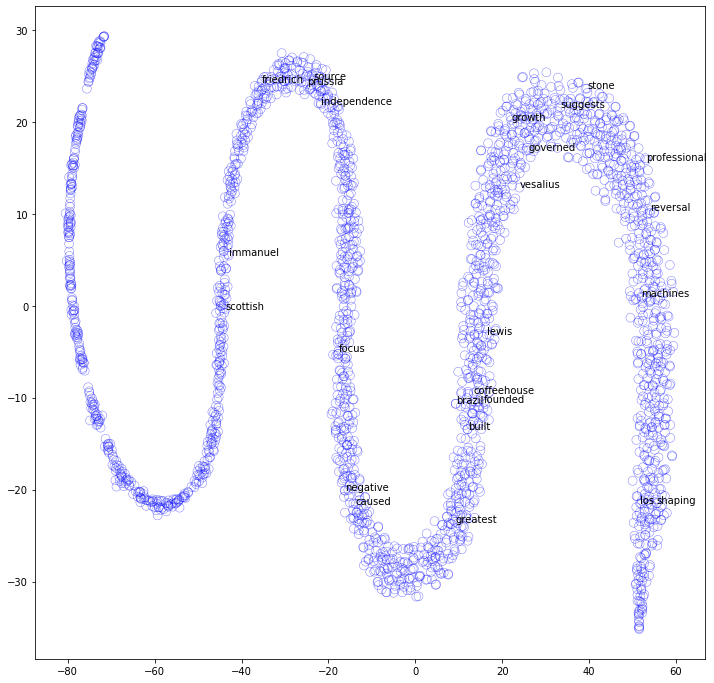

In [ ]:
# Extracción de embeddings y embeddings pre-entrenados.
# !pip install --upgrade gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Embeddings para la colección de juguete del ejercicio 1 (reutilizando la variable "texts").
words = [[word for word in simple_preprocess(text) if word not in stoplist] for text in texts]
model = Word2Vec(words).wv

#esto es para descargarlo en local
# !wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
# premodel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

print(model.most_similar(["paradox"], topn=20))
print(premodel.most_similar(["paradox"], topn=20))


#funciones a modo ilustrativo de por ejemplo encontrar los más similares
def reduce_dimensions(model):
  from sklearn.decomposition import IncrementalPCA    # inital reduction
  from sklearn.manifold import TSNE                   # final reduction
  num_dimensions = 2  # final num dimensions (2D, 3D, etc)
  tsne = TSNE(n_components=num_dimensions, random_state=0)
  vectors = tsne.fit_transform(np.asarray(model.vectors))
  return [v[0] for v in vectors], [v[1] for v in vectors], np.asarray(model.index_to_key)

def plot(x_vals, y_vals, labels):
  import matplotlib.pyplot as plt
  import random
  plt.figure(figsize=(12, 12))
  plt.scatter(x_vals, y_vals, facecolors='none', edgecolors='b', linewidth=.5, s=80, alpha=.5)
  for i in random.sample(list(range(len(labels))), 25): plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot(*reduce_dimensions(model))

### **Ejercicio: dense retrieval con embeddings.**

Definir una función de ránking no supervisado basada en embeddings. Utilizar las implementaciones de gensym y la colección de juguete del ejercicio 1, u otras opciones a elección del estudiante.

In [ ]:
# Código aquí.

# **5. Opcional: deep learning to rank.**

Aplicar un modelo de deep learning sobre alguno de los conjuntos de datos de los ejercicios anteriores. Por ejemplo, utilizar alguno de los modelos disponibles en PyTerrier.

In [ ]:
# Para ello, vamos a aplicar un modelo de ranking basado en neuronas llamado OpenNIR
import sys
import os
import shutil
from collections import namedtuple
sys.path.append('..') # assuming we're running from OpenNIR/examples/
os.environ['ONIR_IGNORE_ARGV'] = 'true' # don't process command line arguments (they come from jupyter)
os.environ['ONIR_PBAR_COLS'] = '' # no ncols for tqdm


In [ ]:
# Para instalar onit.pt
# pip install OpenNIR-XPM

In [ ]:
import pandas as pd
import pyterrier as pt
if not pt.started():
    pt.init(tqdm='notebook')
import onir.pt

In [ ]:
# Sample EPIC re-ranker (trained on msmarco)
rr = onir.pt.reranker.from_checkpoint('epic.msmarco.tar.gz', {'learning_rate': 1e-5})

In [ ]:
dataset = pt.datasets.get_dataset('irds:vaswani')
index_path = './index_vaswani'
if not os.path.exists(index_path):
    indexer = pt.index.IterDictIndexer(index_path)
    index_ref = indexer.index(dataset.get_corpus_iter(), meta=('docno', 'text'))
else:
    index_ref = pt.IndexRef.of(index_path + '/data.properties')
index = pt.IndexFactory.of(index_ref)

In [ ]:
base_pipeline = pt.BatchRetrieve(index, wmodel="BM25") % 100
res = base_pipeline.transform(dataset.get_topics())

pt.Utils.evaluate(res, dataset.get_qrels(), metrics = ['map'])

In [ ]:
rr_pipeline = base_pipeline >> pt.text.get_text(index, "text") >> rr
epic_res = rr_pipeline.transform(dataset.get_topics())

pt.Utils.evaluate(epic_res, dataset.get_qrels(), metrics = ['map'])

In [ ]:
# (over)fit 1 training iteration on the vaswani dataset
rr_pipeline.fit(dataset.get_topics(), dataset.get_qrels())

In [ ]:
# (over)fit many training iterations on the vaswani dataset
rr_pipeline.fit(dataset.get_topics(), dataset.get_qrels(), dataset.get_topics(), dataset.get_qrels())

In [ ]:
# Train on a pair iterator (also works with dataframe of same columns)
def tr_pairs():
    import ir_datasets
    ds = ir_datasets.load('msmarco-passage/train')
    queries = {q.query_id: q for q in ds.queries_iter()}
    docstore = ds.docs_store()
    for scoreddoc in ds.docpairs_iter():
        yield onir.pt.TrainPair(
            scoreddoc.query_id,
            queries[scoreddoc.query_id].text,
            scoreddoc.doc_id_a,
            docstore.get(scoreddoc.doc_id_a).text,
            scoreddoc.doc_id_b,
            docstore.get(scoreddoc.doc_id_b).text)
rr.fit(tr_pairs=tr_pairs())

# **References**


* [1] Information Retrieval – Implementing and Evaluating Search Engines Stefan Büttcher, Charles L. A. Clarke, Gordon V. Cormack, 2010 *

* [2] Search Engines: Information Retrieval in Practice
W. B. Croft, D. Meltzer, T. Strohman, 2010*

# **Anexo**

Hemos desarrollado Query Likelihood con suavizado Dirichlet. Sin embargo, con QL, se pueden econtrar **similitudes con TF-IDF**. De hecho **reordenándo términos** en QLD, **obtenemos** una expresión TF-IDF proporcional a $log(q|d)$. Tal que:

$$ log(p(q|d)) \propto \sum_{w \in q}log(\frac{ \mu + frec(w,d) \sum_{d' \in D} |d'|  / \sum_{d' \in D} frec(w,d') }{\mu + |d|}) $$




Así que para ello hemos **desarrollado la variante QLD_TFIF:**

In [84]:
#VERSION 2!!!!!!!
#CONEXION CON TF-IDF

from numpy.core.fromnumeric import prod
class QLD_TFIDF:
  def __init__(self, freqvector, wordfreqs, mu):
    self.freqvector = freqvector
    self.wordfreqs = wordfreqs
    self.mu = mu

    self.d = {url:sum(c.values()) for (url,c) in self.freqvector.items()}
    self.sum_all_d = np.sum([d for d in self.d.values()])
   


  def search(self, q):

    ranking = [(url, self.score(q,url) ) for url in self.freqvector.keys() ]
    # Eliminamos los documentos con score = 0.
    #######ranking = [(url, score) for url, score in ranking if score > 0]
    #Ordenamos el ranking
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking


  def score(self, q, d):

    w_e_q = [ self.score_por_palabra(w,d) for w in q]
    return sum(w_e_q)

  def score_por_palabra(self, w,d):
    freq_w_d = self.freqvector[d][w]
    numerador = self.mu + (freq_w_d * (self.sum_all_d / self.wordfreqs[w])   ) 
    denominador = self.mu + self.d[d]
    return np.log(numerador/ denominador)



También podemos ver una **similitud de QLD con QLJM** (es decir con otro tipo de suavizado). Obteniendo que nuestro score es proporcional tal que la **siguiente expresión:**
$$ log(p(q|d)) \propto \sum_{w \in q}log(1 + \frac{frec(w,d)}{\mu} \frac{\sum_{d' \in D} |d'|}{\sum_{d' \in D} frec(w,d')}) - |q| log(1 + \frac{|d|}{\mu})$$


Así que para ello hemos **desarrollado la variante QLD_2:**

In [83]:
#CONEXION CON QLJM Y AJUSTE DE MU
from numpy.core.fromnumeric import prod
class QLD_2:
  def __init__(self, freqvector, wordfreqs, mu):
    self.freqvector = freqvector
    self.wordfreqs = wordfreqs
    self.mu = mu

    self.d = {url:sum(c.values()) for (url,c) in self.freqvector.items()}
    self.sum_all_d = np.sum([d for d in self.d.values()])
   


  def search(self, q):

    ranking = [(url, self.score(q,url) ) for url in self.freqvector.keys() ]
    # Eliminamos los documentos con score = 0.
    #######ranking = [(url, score) for url, score in ranking if score > 0]
    #Ordenamos el ranking
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def score(self, q, d):
    ''' Devuelve el log de p((q|d) ), es decir, el score del modelo para una query y un doc.
    '''

    #Termino que resta
    last_term = len(q) * np.log(1+ ( self.d[d] / self.mu) )
    w_e_q = [ (self.p_of_w_given_d(w, d) - last_term ) for w in q]
    #w_e_q = [ self.p_of_w_given_d(w, d)   for w in q]
    #w_e_q = [ w - last_term    for w in w_e_q]
    
    return sum(w_e_q)

  def p_of_w_given_d(self,w,d):
    #Devuelve p(w|q), es decir, el primer sumando de el sumatorio dentro de la fórmula
    freq_w_d = self.freqvector[d][w]
    product = ( freq_w_d/ self.mu ) * (self.sum_all_d / self.wordfreqs[w] )
    return np.log(1 + product)

Para ver si a pesar de ser proporcianales, vamos a probar con el ejemplo de la query de las diapositivas "what to think", **si en una pequeña collección, se ve el orden MUY alterado:**


In [85]:
 #TESTEO CON LOS EJEMPLOS DE LAS DIAPOSITIVAS DE CLASE:
urls = ["d1",
        "d2",
        "d3",
        "d4",
        "d5",
        "d6",
        "d7",
        ]

texts = []
texts.append('i think therefore i am')
texts.append('i know one thing that i know nothing')
texts.append('i think to do is to be, to be is to do')
texts.append('you are what you do when it counts')
texts.append('in teaching others we teach ourselves')
texts.append('i cannot live without books')
texts.append('think what next')


# Vector de frecuencias para todos los documentos de la colección, usando la subclase de diccionario collections.Counter.
# Para cada documento, counter almacena un diccionario palabra:frecuencia.
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text.lower()) ]) for url, text in zip(urls, texts)}
# Document frequency para cada palabra del vocabulario.
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}
# Frecuencia total para cada palabra del vocabulario.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Probamos tres consultas.
for q in [['what', 'to', 'think']]:
  print('\n------------------------------')
  print('Query:', q)

  print('\nQLD_Original(desarrollado en el ejercicio 1)')
  for url, score in QLD(freqvector, wordfreqs, mu=10).search(q):
    print(score, url)

  print('\nQLD_TF-IDF')
  for url, score in QLD_TFIDF(freqvector, wordfreqs, mu=10).search(q):
    print(score, url)

  print('\n QLD_2')
  for url, score in QLD_2(freqvector, wordfreqs, mu=10).search(q):
    print(score, url)



------------------------------
Query: ['what', 'to', 'think']

QLD_Original(desarrollado en el ejercicio 1)
-7.0079133821562 d7
-8.054686840843008 d3
-8.646176258915194 d1
-8.926788623651612 d4
-9.588784299106724 d6
-9.782399862519437 d5
-10.135748969488589 d2

QLD_TF-IDF
1.3644755926260304 d7
0.3177021339392223 d3
-0.2737872841329648 d1
-0.5543996488693819 d4
-1.2163953243244934 d6
-1.4100108877372066 d5
-1.7633599947063567 d2

 QLD_2
-0.20970999417891611 d7
-2.706577932781951 d1
-3.6491859729734797 d6
-4.081119638282097 d4
-4.23003266321162 d5
-4.4130420282464 d3
-5.290079984119071 d2


Observamos como la versión del TF-IF nos devuelve el mismo ranking, sin embargo la versión con la conexión a QLJM, no altera bastante el ranking, mandándonos el segundo elemento al la penúltima posición. Por lo que en este últmo caso deberíamos variar los hiperparámetros para obtener un mejor ranking.